<a href="https://colab.research.google.com/github/Kate-Zilla/CNN_cancer_histology/blob/main/CNN_histo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

verify my local runtime is working

In [1]:
import sys, platform, tensorflow as tf
print("Python:", sys.version.split()[0], "| TF:", tf.__version__, "| Platform:", platform.platform())
print("TF devices:", tf.config.list_physical_devices())


Python: 3.12.3 | TF: 2.16.2 | Platform: Windows-11-10.0.26100-SP0
TF devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


local folder layout (i,e... if you're reading this on git and want to reproduce, get your folders in order!)

In [2]:
DATA_DIR = "D:/Coursera/Intro to Deep Learning/module 3"

import os
print("Files in DATA_DIR:", os.listdir(DATA_DIR))
print("Files in train/:", os.listdir(os.path.join(DATA_DIR, "train"))[:5])  # show first 5 files


Files in DATA_DIR: ['colab-local', 'histo_CNN.ipynb', 'sample_submission.csv', 'test', 'train', 'train_labels.csv']
Files in train/: ['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', '000020de2aa6193f4c160e398a8edea95b1da598.tif', '00004aab08381d25d315384d646f5ce413ea24b1.tif', '0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif', '0000da768d06b879e5754c43e2298ce48726f722.tif']


load training labels & do a sanity check

In [3]:
import os, pandas as pd
from pathlib import Path

DATA_DIR = Path("D:/Coursera/Intro to Deep Learning/module 3")
CSV = DATA_DIR / "train_labels.csv"
TRAIN = DATA_DIR / "train"
TEST  = DATA_DIR / "test"

df = pd.read_csv(CSV)  # columns: id,label
df["filepath"] = df["id"].apply(lambda s: str(TRAIN / f"{s}.tif"))

print(df.head())
print("rows:", len(df), "| positives:", int(df['label'].sum()))
SAMPLE = 1000
ok = df["filepath"].sample(SAMPLE, random_state=42).map(os.path.exists).mean()
print(f"Sample exists %: {ok*100:.2f}%")


                                         id  label  \
0  f38a6374c348f90b587e046aac6079959adf3835      0   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1   
2  755db6279dae599ebb4d39a9123cce439965282d      0   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0   
4  068aba587a4950175d04c680d38943fd488d6a9d      0   

                                            filepath  
0  D:\Coursera\Intro to Deep Learning\module 3\tr...  
1  D:\Coursera\Intro to Deep Learning\module 3\tr...  
2  D:\Coursera\Intro to Deep Learning\module 3\tr...  
3  D:\Coursera\Intro to Deep Learning\module 3\tr...  
4  D:\Coursera\Intro to Deep Learning\module 3\tr...  
rows: 220025 | positives: 89117
Sample exists %: 100.00%


more imports

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image  #PIL handles .tif just fine
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

EDA

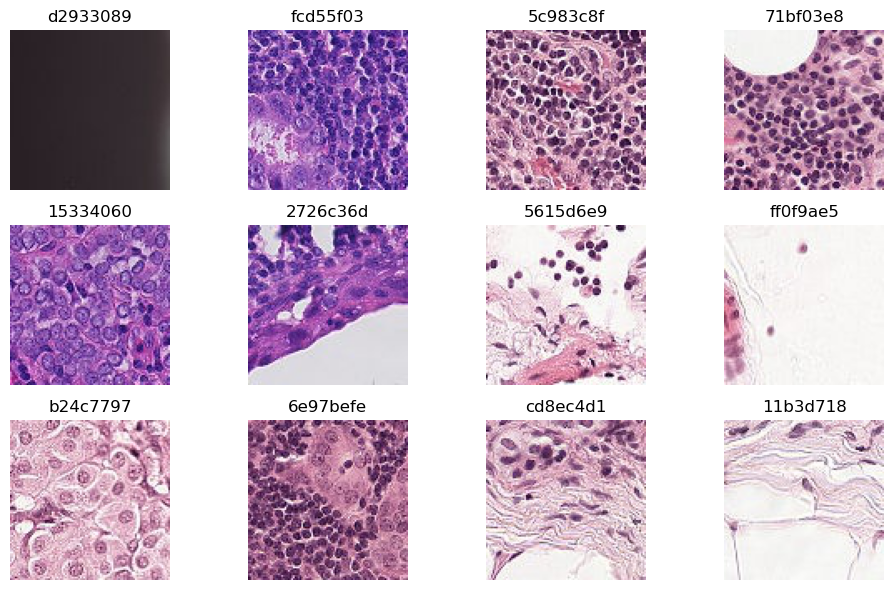

In [14]:


sample_ids = df.sample(12, random_state=42)["id"].tolist()

plt.figure(figsize=(10,6))
for i, sid in enumerate(sample_ids):
    p = os.path.join(TRAIN, f"{sid}.tif")
    with Image.open(p) as im:
        im = im.convert("RGB")        # ensure 3 channels
        img = np.array(im)            # to numpy array for imshow
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(sid[:8])
plt.tight_layout(); plt.show()


split it up!

In [16]:
DATA_DIR = Path(r"D:/Coursera/Intro to Deep Learning/module 3")
TRAIN    = DATA_DIR / "train"
TEST     = DATA_DIR / "test"
CSV      = DATA_DIR / "train_labels.csv"

df = pd.read_csv(CSV)                     # columns: id,label
df["filepath"] = df["id"].apply(lambda s: str(TRAIN / f"{s}.tif"))

SEED = 42
train_p, val_p, train_y, val_y = train_test_split(
    df["filepath"].values,
    df["label"].values,
    test_size=0.1,
    stratify=df["label"].values,
    random_state=SEED
)

IMG_SIZE = (96, 96)
BATCH    = 64
AUTOTUNE = tf.data.AUTOTUNE

def _load_tiff(path_bytes):
    p = path_bytes.decode()
    with Image.open(p) as im:
        im = im.convert("RGB")
        im = im.resize(IMG_SIZE, resample=Image.BILINEAR)
        arr = np.asarray(im, dtype=np.float32) / 255.0
    return arr

def decode_img(path):
    img = tf.numpy_function(_load_tiff, [path], tf.float32)
    img.set_shape((*IMG_SIZE, 3))   # static shape for TF
    return img

def make_ds(paths, labels=None, training=False):
    if labels is not None:
        ds = tf.data.Dataset.from_tensor_slices((paths, labels))
        ds = ds.map(lambda p,y: (decode_img(p), tf.cast(y, tf.float32)),
                    num_parallel_calls=AUTOTUNE)
        if training:
            ds = ds.shuffle(8192, seed=SEED)
    else:
        ds = tf.data.Dataset.from_tensor_slices(paths)
        ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    return ds.batch(BATCH).prefetch(AUTOTUNE)

train_ds = make_ds(train_p, train_y, training=True)
val_ds   = make_ds(val_p,   val_y,   training=False)

for x,y in train_ds.take(1):
    print("train batch:", x.shape, y.shape)

train batch: (64, 96, 96, 3) (64,)


train the CNN

In [17]:
IMG_SIZE = (96, 96)
EPOCHS   = 8

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = layers.Conv2D(32, 3, padding="same", activation="relu")(inputs); x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x);     x = layers.MaxPool2D()(x)
x = layers.Conv2D(128,3, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=[keras.metrics.AUC(name="AUC"), "accuracy"])

callbacks = [
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, verbose=1, monitor="val_AUC", mode="max"),
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_AUC", mode="max"),
]
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/8
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1982s 638ms/step - AUC: 0.8774 - accuracy: 0.8068 - loss: 0.4284 - val_AUC: 0.9112 - val_accuracy: 0.8346 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 2/8
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1413s 421ms/step - AUC: 0.9142 - accuracy: 0.8454 - loss: 0.3631 - val_AUC: 0.9237 - val_accuracy: 0.8305 - val_loss: 0.3764 - learning_rate: 0.0010
Epoch 3/8
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1393s 430ms/step - AUC: 0.9303 - accuracy: 0.8620 - loss: 0.3300 - val_AUC: 0.9397 - val_accuracy: 0.8700 - val_loss: 0.3128 - learning_rate: 0.0010
Epoch 4/8
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 2152s 678ms/step - AUC: 0.9418 - accuracy: 0.8757 - loss: 0.3027 - val_AUC: 0.9555 - val_accuracy: 0.8866 - val_loss: 0.2713 - learning_rate: 0.0010
Epoch 5/8
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1393s 414ms/step - AUC: 0.9499 - accuracy: 0.8866 - loss: 0.2805 - val_AUC: 0.9602 - val_accuracy: 0.8955 - val_loss: 0.2620 - learning_rate: 0.0010
Epoch 6/8
3095/3095 ━━━━━━━━━━━━━━━━━━━━ 1391s 428

validate

In [18]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

try:
    y_true = val_y.astype(int)
except NameError:
    y_true = np.concatenate([y.numpy().astype(int) for _, y in val_ds], axis=0)

y_prob = model.predict(val_ds, verbose=0).ravel()

val_auc = roc_auc_score(y_true, y_prob)
print("Validation AUC:", round(val_auc, 4))

#for assignment writeup only, not for purposes of kaggle submission
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_true, y_pred, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))


Validation AUC: 0.9695
              precision    recall  f1-score   support

           0     0.9089    0.9443    0.9263     13091
           1     0.9132    0.8610    0.8863      8912

    accuracy                         0.9106     22003
   macro avg     0.9111    0.9026    0.9063     22003
weighted avg     0.9107    0.9106    0.9101     22003

Confusion matrix:
 [[12362   729]
 [ 1239  7673]]


build test dataset

In [19]:
import tensorflow as tf, numpy as np, pandas as pd
from pathlib import Path

sample_sub = pd.read_csv(DATA_DIR / "sample_submission.csv")
test_paths = sample_sub["id"].apply(lambda s: str(TEST / f"{s}.tif")).values

if 'make_ds' in globals():
    test_ds = make_ds(test_paths, labels=None, training=False)
else:
    from PIL import Image
    IMG_SIZE = (96, 96)
    AUTOTUNE = tf.data.AUTOTUNE
    INF_BATCH = 256

    def _load_tiff_infer(path_bytes):
        p = path_bytes.decode()
        with Image.open(p) as im:
            im = im.convert("RGB").resize(IMG_SIZE, resample=Image.BILINEAR)
            arr = np.asarray(im, dtype=np.float32) / 255.0
        return arr

    def decode_infer(path):
        img = tf.numpy_function(_load_tiff_infer, [path], tf.float32)
        img.set_shape((*IMG_SIZE, 3))
        return img

    test_ds = (
        tf.data.Dataset.from_tensor_slices(test_paths)
        .map(decode_infer, num_parallel_calls=AUTOTUNE)
        .batch(INF_BATCH)
        .prefetch(AUTOTUNE)
        .with_options(tf.data.Options())
    )
    opts = tf.data.Options()
    opts.threading.private_threadpool_size = 8
    opts.experimental_deterministic = False
    test_ds = test_ds.with_options(opts)


make prediction & build kaggle submission

In [20]:
use_model = model

test_prob = use_model.predict(test_ds, verbose=1).ravel()

sub = sample_sub.copy()
sub["label"] = test_prob

sub_path = Path.cwd() / "submission.csv"
sub.to_csv(sub_path, index=False)
print("Wrote:", sub_path)
sub.head()


898/898 ━━━━━━━━━━━━━━━━━━━━ 422s 469ms/step
Wrote: D:\Coursera\Intro to Deep Learning\module 3\submission.csv


,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.030292
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.240852
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.040041
3,2c35657e312966e9294eac6841726ff3a748febf,0.099588
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.039076
